## <span style="color:blue;">STEP 1: DATA VISUALIZATION</span>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

X = np.load('X.npy')
y = np.load('y.npy')  

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (800, 1000, 501)
y shape: (800,)


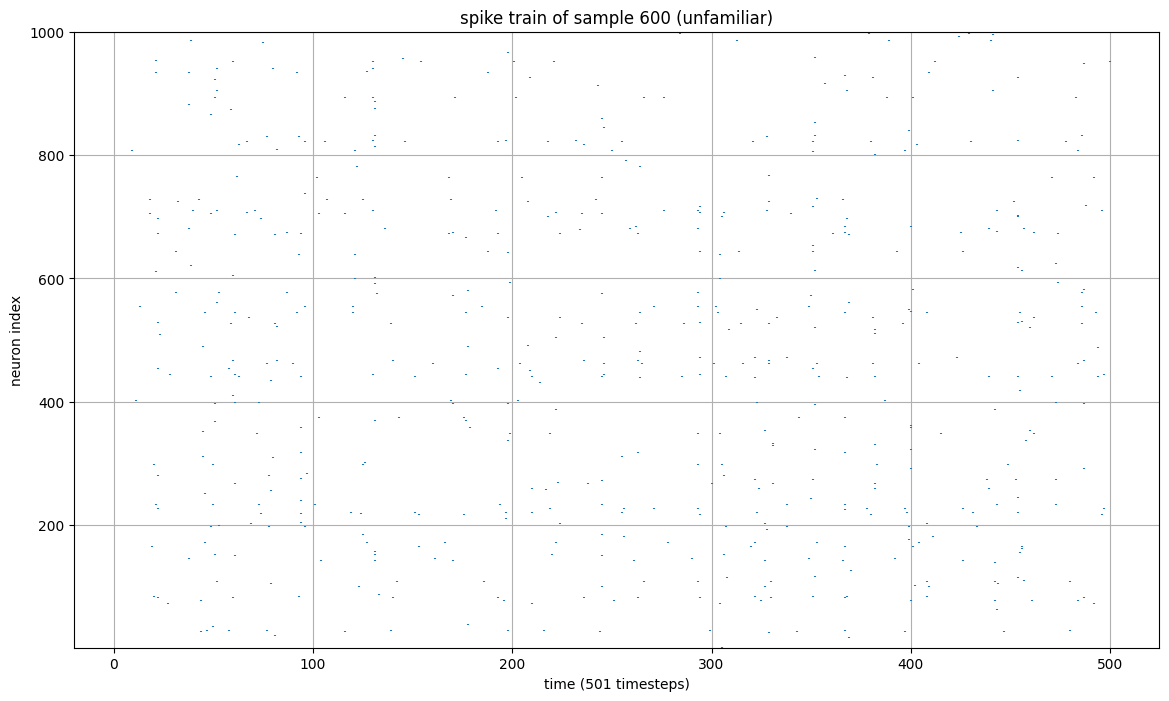

In [2]:
########################### look at one idividual sample #########################

sample_nr=600
sample = X[sample_nr] 
label = y[sample_nr]


plt.figure(figsize=(14, 8))

for neuron_idx in range(1000):
    spike_times = np.where(sample[neuron_idx] > 0)[0]
    plt.vlines(spike_times, neuron_idx + 0.5, neuron_idx + 1.5)

plt.title(f"spike train of sample {sample_nr} {'(familiar)' if label == 1 else '(unfamiliar)'}")
plt.xlabel("time (501 timesteps)")
plt.ylabel("neuron index")
plt.ylim(0.5, 1000.5)
plt.grid(True)
#plt.tight_layout()
plt.show()


#### Observations:

In some samples I see that some neurons fire together in waves, resulting in an almost vertically striped pattern.
    -> I should look at population coding  

## <span style="color:blue;">STEP 2: DATA TRANSFORMATION</span>
### Neural coding techniques I'd like to try:

#### Rate Coding:
    -Compute Mean Firing Rate (average spikes per neuron over time).
    -Compute Fano Factor (variability of spike counts over time).

#### Temporal Coding:
    -Fast Fourier Transform(FFT).
        -Power in low-frequency bands (0–40 Hz).
        -Peak frequencies (frequency with highest power).

#### Population Coding:
    Synchrony Variance (how much neurons fire together at each time point).

In [3]:
def compute_features(X):
    n_samples = X.shape[0]
    features = []

    for i in range(n_samples):
        x = X[i]

        #total spikes
        total_spikes = np.sum(x)

        #mean firing rate
        mean_firing_rate = total_spikes / (x.shape[0] * x.shape[1])

        #synchrony variance
        total_spikes_per_time = np.sum(x, axis=0)
        synchrony_variance = np.var(total_spikes_per_time)

         # Fano Factor
        mean_spikes = np.mean(total_spikes_per_time)
        var_spikes = np.var(total_spikes_per_time)
        fano_factor = var_spikes / mean_spikes

        #fast forurier transormation------------------------------------------------------------------
        
        #apply fft
        fft = np.fft.fft(total_spikes_per_time)
        fft = fft[:len(fft)//2]#keep only positive frequencies

        #power--------------------------

        power = np.mean(np.abs(fft[:20]) ** 2)#only first 20 bins(40Hz)

        #peak frequency-----------------

        #i remove the mean from the total spikes because else shows peak frequencies at 0 (DC component)
        total_spikes_per_time = total_spikes_per_time - np.mean(total_spikes_per_time)

        #remove everything above 40Hz (20 bins)
        fft = np.fft.fft(total_spikes_per_time[:20])

        #remove 0 hz component (DC component)
        fft[0] = 0

        #redo fft
        #fft = np.fft.fft(total_spikes_per_time)
        fft = fft[:len(fft)//2]#keep only positive frequencies

        #find the bin with the highest power
        peak_idx = np.argmax(np.abs(fft))

        #i could do this fancier but i am not even quite sure if 1 timestep is really 1ms
        #i just want the scale to be more interpretable
        peak_frequency = peak_idx * 2 #so 2 Hz per bin

        

        #----------------------------------------------------------------------------------------------

        #collect features in dict
        sample_features = {
            'mean_firing_rate': mean_firing_rate,
            'synchrony_variance': synchrony_variance,
            'power': power,
            'peak_frequency': peak_frequency,
            'fano_factor': fano_factor
        }

        features.append(sample_features)

    #make a dataframe so i dont get cofused with axis anymore
    features_df = pd.DataFrame(features)

    return features_df

  
#just for testing purposes
#print(features.shape)
#print ("mfr:", features[:, 0])
#print ("sv:", features[:, 1])
#print ("power:", features[:, 2])



## <span style="color:blue;">STEP 3: EXPLORATORY ANALYSIS</span>

   mean_firing_rate  synchrony_variance         power  peak_frequency  \
0          0.000940            8.806794  21015.856734               2   
1          0.001250            9.101422  28816.224794               2   
2          0.001220           14.738220  31917.141044               0   
3          0.001393           14.470134  35810.307385               8   
4          0.001335           13.340648  37248.408671              18   

   fano_factor  
0     9.367736  
1     7.284045  
2    12.084858  
3    10.386156  
4     9.990530  


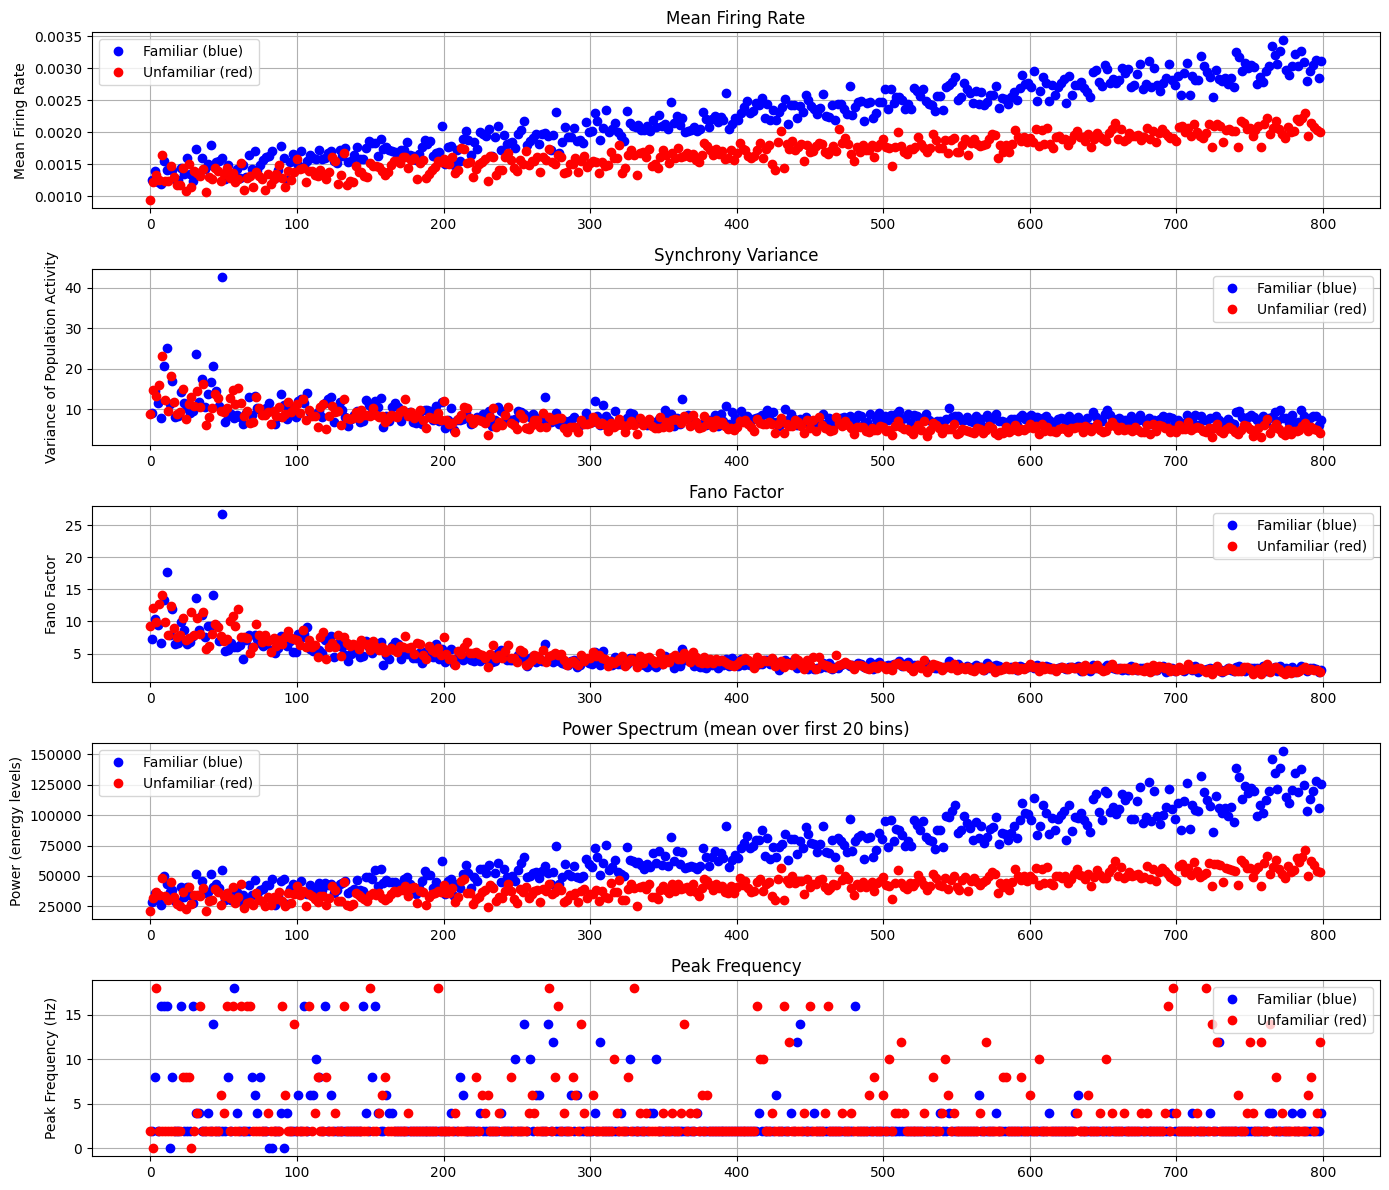

In [4]:
############### PLOT EVERYTHING ####################

features = compute_features(X)

nr_of_features=5

# print first 5 samples for quick check
print(features.head())

plt.figure(figsize=(14, 12))

# 1. Mean Firing Rate
plt.subplot(nr_of_features, 1, 1)
plt.title("Mean Firing Rate")
plt.ylabel("Mean Firing Rate")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'mean_firing_rate'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'mean_firing_rate'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 2. Synchrony Variance
plt.subplot(nr_of_features, 1, 2)
plt.title("Synchrony Variance")
plt.ylabel("Variance of Population Activity")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'synchrony_variance'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'synchrony_variance'], 'ro', label='Unfamiliar (red)')
plt.legend()

#3. Fano Factor
plt.subplot(nr_of_features, 1, 3)
plt.title("Fano Factor")
plt.ylabel("Fano Factor")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'fano_factor'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'fano_factor'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 4. Power
plt.subplot(nr_of_features, 1, 4)
plt.title("Power Spectrum (mean over first 20 bins)")
plt.ylabel("Power (energy levels)")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'power'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'power'], 'ro', label='Unfamiliar (red)')
plt.legend()

# 5. Peak Frequency
plt.subplot(nr_of_features, 1, 5)
plt.title("Peak Frequency")
plt.ylabel("Peak Frequency (Hz)")
plt.grid(True)
plt.plot(np.where(y == 1)[0], features.loc[y == 1, 'peak_frequency'], 'bo', label='Familiar (blue)')
plt.plot(np.where(y == 0)[0], features.loc[y == 0, 'peak_frequency'], 'ro', label='Unfamiliar (red)')
plt.legend()



plt.tight_layout()
plt.show()




### <span style="color:blue;">Observations</span>

-The earlier samples are providing overall less secure evidence for being familiar/not familiar than the later ones.(Maybe the neurons became more tuned to the stimuli over time.)

-The mean firing rate and the power of lower frequencies seem to provide strong distinctions between the two groups. Familiar examples show a higher firing rate than unfamiliar ones.

-Fano factor and peak frequencies can probably be ignored as it is unclear from the plots that the two groups differ. Maybe from from the variance of population activity I could extract some information, but it looks weak.

#### Further explaination of the methods used

-The mean firing rate was calculated by summing all spikes across neurons and dividing by the total number of neuron-time combinations (number of neurons × number of timepoints).

-Instead of printing the fft in its raw form, I used power (|fft signal|^2) and looked at the mean of the first 20 bins. This should give a detailed enough view of lower frequencies, while ignoring the high frequency noise. Frequency per bin=1/T. 1/0.5sec (assuming one time point is one millisecond) would make one bin be equivalent to (roughly) 2Hz. So 20 bins cover ca. 40Hz ​ 

-Peak frequency: After removing the mean from the spike signal, I applied FFT and then identified the frequency bin with the highest value. At first, the frequencies looked very random but after removing all peaks above 40Hz (and zero ones), i identified that there seems to be a prominent and consistent 2Hz Signal in all the samples. I can not distinguish the two groups for now, but maybe this will be interesting later?

-To capture how synchronized the population activity is, I summed spikes across neurons at each timepoint and calculated the variance over time. A higher variance suggests more synchronous bursts of activity, while lower variance indicates more random firing.

-For each trial I computed the mean and variance of the summed spike counts across time bins. The Fano factor is the variance divided by the mean. It measures how regular or irregular the firing is.



In [5]:
###################### Inspect Power Spectrum ####################

power= features['power'].values

peak_freqs = features['peak_frequency'].values

#divide into familiar and unfamiliar
peak_fam = peak_freqs[y == 1]
peak_unfam = peak_freqs[y == 0]

#calculating standard deviations
std_fam = np.sqrt(np.mean((peak_fam - np.mean(peak_fam)) ** 2))
std_unfam = np.sqrt(np.mean((peak_unfam - np.mean(peak_unfam)) ** 2))
std_peak = np.sqrt(np.mean((peak_freqs - np.mean(peak_freqs)) ** 2))


print(f"{'':<15}{'Mean(Hz)':>15}{'Std(Hz)':>15}")
print("-" * 50)
print(f"{'Familiar':<15}{np.mean(peak_fam):>15.2f}{std_fam:>15.2f}")
print(f"{'Unfamiliar':<15}{np.mean(peak_unfam):>15.2f}{std_unfam:>15.2f}")
print(f"{'Overall (Peak)':<15}{np.mean(peak_freqs):>15.2f}{std_peak:>15.2f}")

                      Mean(Hz)        Std(Hz)
--------------------------------------------------
Familiar                  3.12           3.03
Unfamiliar                3.94           3.94
Overall (Peak)            3.53           3.54


In [6]:
###################### Inspect Fano Factor ####################

fano = features['fano_factor'].values

#divide into familiar and unfamiliar
fano_fam = fano[y == 1]
fano_unfam = fano[y == 0]

#calculating standard deviations
std_fam = np.sqrt(np.mean((fano_fam - np.mean(fano_fam)) ** 2))
std_unfam = np.sqrt(np.mean((fano_unfam - np.mean(fano_unfam)) ** 2))
std_fano = np.sqrt(np.mean((fano - np.mean(fano)) ** 2))

# print table
print(f"{'':<15}{'Mean':>15}{'Std':>15}")
print("-" * 45)
print(f"{'Familiar':<15}{np.mean(fano_fam):>15.2f}{std_fam:>15.2f}")
print(f"{'Unfamiliar':<15}{np.mean(fano_unfam):>15.2f}{std_unfam:>15.2f}")
print(f"{'Overall (Fano)':<15}{np.mean(fano):>15.2f}{std_fano:>15.2f}")


                          Mean            Std
---------------------------------------------
Familiar                  4.15           2.30
Unfamiliar                4.35           2.16
Overall (Fano)            4.25           2.23


I analyzed how much the neurons fire, how rhythmically they fire, and how much they fire together. I assessed which measurements are reliable. But now, they are still reliant on the sample-index-x-axis. Since a random new sample is unlikely to come with data about how far the experiment has progressed at the time of measurement, I should not include it in the classifier.

Now I can start to combine my best estimators


In [8]:
######################## Feature Distributions Histograms ######################## 

def plot_feature_distributions(features, y, feature_list):
    n_features = len(feature_list)
    n_cols = 2 #how many plots per row
    n_rows = (n_features + n_cols - 1) // n_cols #compute rows automatically B)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
    axes = axes.flatten() #flatten to make it easy to index

    for idx, feature_name in enumerate(feature_list):
        fam_values = features.loc[y == 1, feature_name].values
        unfam_values = features.loc[y == 0, feature_name].values

        ax = axes[idx]
        ax.hist(fam_values, bins=20, alpha=0.5, label='Familiar', color='blue', density=True)# density=True here the histogram gets normalized
        ax.hist(unfam_values, bins=20, alpha=0.5, label='Unfamiliar', color='red', density=True)
        ax.set_title(f"{feature_name}")
        ax.set_xlabel(feature_name)
        ax.set_ylabel("Density")
        ax.grid(True)

    #hide empty subplots
    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.legend()
    plt.show()



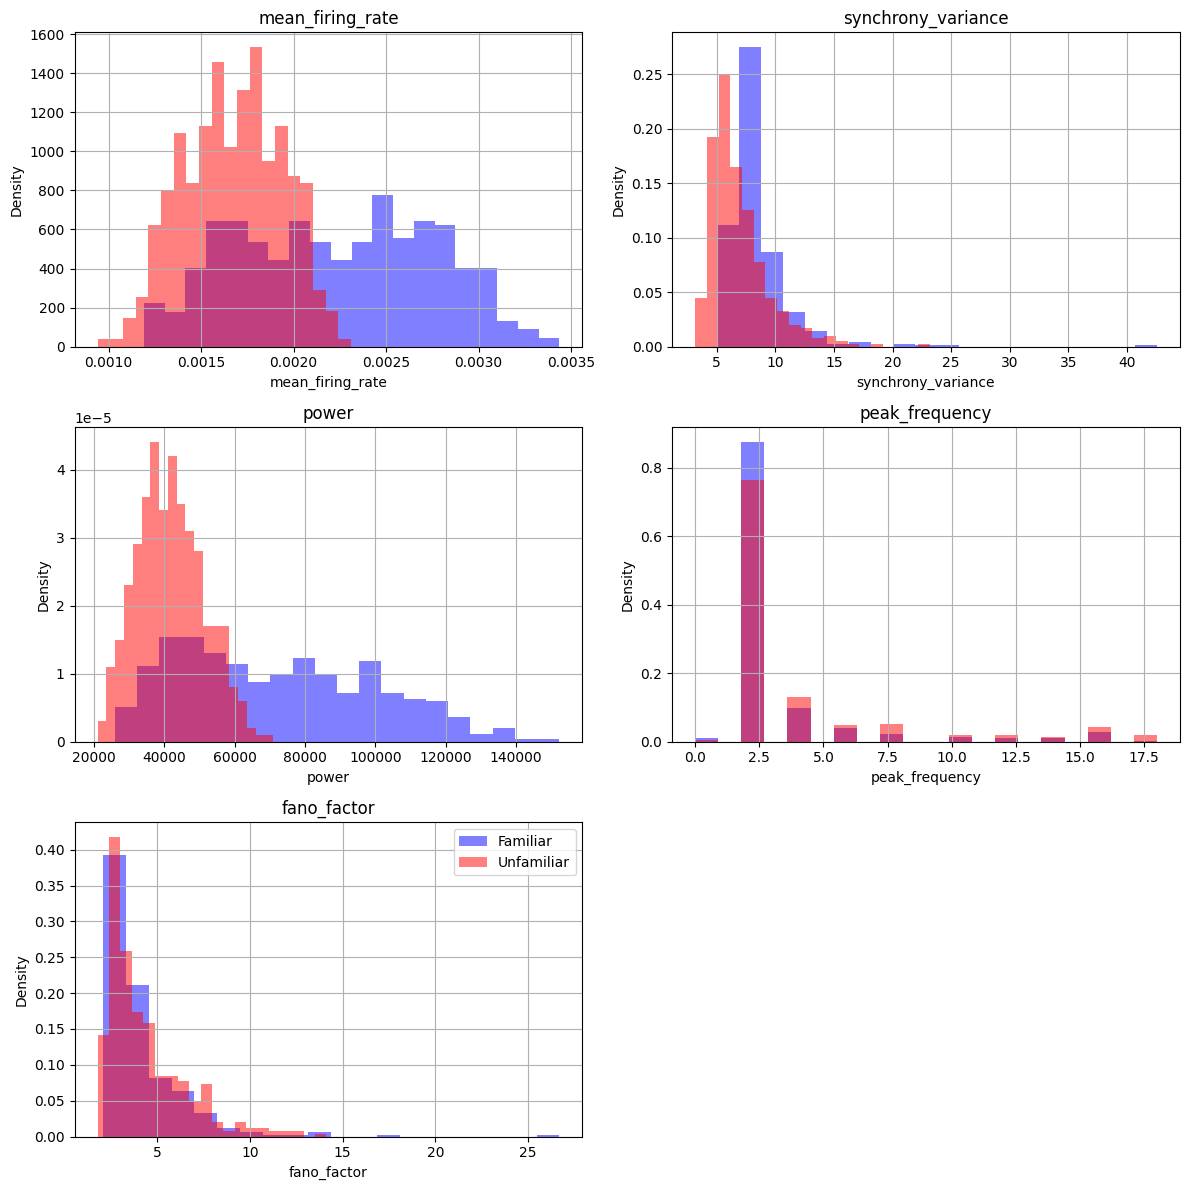

In [9]:
feature_list = ['mean_firing_rate', 'synchrony_variance', 'power', 'peak_frequency', 'fano_factor']

plot_feature_distributions(features, y, feature_list)

I used overlaid histograms normalized to density.
Histograms are a more intuitive visualization of the full distribution of feature values.
The focus is on shape and spread, not total counts.

There remains a great overlap between the groups, so perfect classification based on any single feature alone is impossible.

In [ ]:
######################## Compute Cohen's d ########################

def cohen_d(x, y):
    #calculate cohen's d for two samples
    mean_x, mean_y = np.mean(x), np.mean(y)# calculate means
    var_x, var_y = np.var(x, ddof=1), np.var(y, ddof=1)# calculate variances
    pooled_std = np.sqrt((var_x + var_y) / 2)# pooled standard deviation
    d = (mean_x - mean_y) / pooled_std#
    return d

feature_list = ['mean_firing_rate', 'synchrony_variance', 'power', 'peak_frequency', 'fano_factor']

print(f"{'Feature':<25}{'Cohen´s d':>10}")
print("_" * 40)

#loop over all features 
for feature_name in feature_list:
    fam_values = features.loc[y == 1, feature_name].values
    unfam_values = features.loc[y == 0, feature_name].values

    d = cohen_d(fam_values, unfam_values)
    print(f"{feature_name:<25}{d:>10.2f}")

Feature                   Cohen´s d
________________________________________
mean_firing_rate               1.36
synchrony_variance             0.59
power                          1.46
peak_frequency                -0.23
fano_factor                   -0.09


### <span style="color:blue;">Observations</span>

Cohen’s d measures the difference between two group means, divided by their pooled standard deviation.


It shows how far apart the groups are in terms of their typical variation.
As expected, mean firing rate and low-frequency power show strong separation between familiar and unfamiliar trials. Synchrony variance shows moderate separation, peak frequency and fano factor little to none.

Mean firing rate and power remain the two most promising measurements.

## <span style="color:blue;">STEP 4: MODEL TRAINING AND CLASSIFICATION</span>